Adult Dataset - Selection of Queries
=============================

In [1]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.cluster import spectral_clustering

from mbi import Domain
from mbi.junction_tree import JunctionTree
from mechanism import Mechanism

### Load the dataset and its domain

**TODO**: please configure `DATA_PATH`.

In [2]:
# Find the best queries to ask by non-privately analyzing the provisional dataset (assumed to be public)

DATA_PATH = Path('/home/nap/Workspace/Privacy-DARC/rmckenna/data')
ADULT_DATASET_PATH = DATA_PATH / Path('adult.csv')
DOMAIN_INFO_PATH = DATA_PATH / 'adult-domain.json'

mechanism = Mechanism(ADULT_DATASET_PATH, DOMAIN_INFO_PATH)

data = mechanism.load_data()
domain = mechanism.domain

2021-08-03 12:00:54.874 | INFO     | mechanism:__init__:61 - Set the dataset path: /home/nap/Workspace/Privacy-DARC/rmckenna/data/adult.csv
2021-08-03 12:00:54.878 | INFO     | mechanism:__init__:66 - Loaded the domain from /home/nap/Workspace/Privacy-DARC/rmckenna/data/adult-domain.json
2021-08-03 12:00:54.879 | DEBUG    | mechanism:__init__:67 - {'age': [0, 1, 2], 'workclass': ['?', 'Federal-gov', 'Local-gov', 'Never-worked', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'fnlwgt': [0, 1, 2, 3, 4, 5], 'education': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'education-num': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 'marital-status': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['?', 'Adm-clerical', 'Armed-Forces

In [3]:
data.df.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
15560,1,4,2,11,8,2,3,0,2,1,0,0,1,23,0
16924,1,6,1,9,12,2,3,0,1,1,2,0,2,35,1
22577,1,4,0,11,8,2,14,0,4,1,0,0,2,39,0
19118,1,4,2,11,8,2,14,0,4,1,0,0,1,7,0
18043,1,4,1,14,14,2,10,0,4,1,0,0,1,39,1
17681,0,4,1,15,9,4,12,1,4,1,0,0,1,39,0
7957,1,4,2,5,3,4,7,3,4,1,0,0,1,39,0
27360,1,4,1,9,12,2,12,0,4,1,0,0,2,39,0
23616,1,5,1,12,13,0,10,1,4,0,0,0,1,39,0
15398,0,7,0,15,9,4,1,3,4,1,0,0,0,39,0


In [4]:
domain

Domain(age: 3, workclass: 9, fnlwgt: 6, education: 16, education-num: 16, marital-status: 7, occupation: 15, relationship: 6, race: 5, sex: 2, capital-gain: 4, capital-loss: 4, hours-per-week: 4, native-country: 42, salary: 2)

### Compute the mutual information

In [5]:
# Calculate the mutual information between every pair of attributes
nb_rows = len(data.df)
mutinf_pairs_df = pd.DataFrame(columns=['attr_1','attr_2', 'score'])
index = 0

for attr_1, attr_2 in itertools.combinations(data.domain.attrs, 2):
    # Get the relative frequency of each value of the two attributes
    A = data.project(attr_1).datavector() / nb_rows
    B = data.project(attr_2).datavector() / nb_rows
    AB = data.project([attr_1, attr_2]).datavector() / nb_rows
    
    # Compute the mutual information of the two attributes
    # P(A, B) * log( P(A, B) / P(A) * P(B) )
    score = np.dot(AB[AB > 0], np.log(AB / np.outer(A, B).flatten())[AB > 0])
    
    # Save the mutual inf. of A, B and B, A at the right index
    mutinf_pairs_df.loc[index] = [attr_1, attr_2, score]
    mutinf_pairs_df.loc[index + 1] = [attr_2, attr_1, score]
    index += 2

# Sort the pairs of attributes by their mutual information
mutinf_pairs_df.sort_values('score', inplace=True)

/tmp/ipykernel_14348/3648603605.py:14: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[AB > 0], np.log(AB / np.outer(A, B).flatten())[AB > 0])


In [6]:
# The 10 pairs of attributes showing the most mutual information
mutinf_pairs_df.tail(10)

,attr_1,attr_2,score
83,occupation,education,0.223663
82,education,occupation,0.223663
156,relationship,sex,0.273147
157,sex,relationship,0.273147
36,workclass,occupation,0.326612
37,occupation,workclass,0.326612
122,marital-status,relationship,0.725501
123,relationship,marital-status,0.725501
78,education,education-num,2.031858
79,education-num,education,2.031858


In [7]:
# NOTE In the original notebook, the pairs containing the three following attributes got a score increased by 100.
# SEX, CITY, INCWAGE
# IDEA They may come from the 1-marginal that are selected from a previous undocumented step?

# Create the graph with the attributes as nodes
graph = nx.Graph()
graph.add_nodes_from(domain.attrs)

# Add an edge between the pairs of attributes weighted by their mutual information (score)
for attr_1, attr_2, score in mutinf_pairs_df.itertuples(index=False):
    graph.add_edge(attr_1, attr_2, weight=score)

# Compute the maximum spanning tree (i.e., the spanning tree which total weight is maximum)
mst = nx.maximum_spanning_tree(graph)
list(mst.edges)

[('age', 'marital-status'),
 ('workclass', 'occupation'),
 ('fnlwgt', 'native-country'),
 ('education', 'education-num'),
 ('education', 'occupation'),
 ('education-num', 'native-country'),
 ('marital-status', 'relationship'),
 ('occupation', 'sex'),
 ('occupation', 'hours-per-week'),
 ('relationship', 'sex'),
 ('relationship', 'salary'),
 ('race', 'native-country'),
 ('capital-gain', 'salary'),
 ('capital-loss', 'salary')]

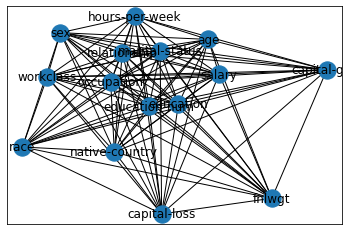

In [8]:
nx.draw_networkx(graph)

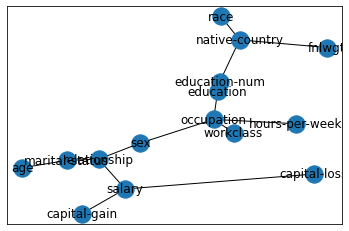

In [9]:
nx.draw_networkx(mst)

In [10]:
mutinf_triplets_df = pd.DataFrame(columns=['A', 'B', 'C', 'size', 'score'])
index = 0

for A in mst.nodes:
    for B, C in itertools.combinations(mst.neighbors(A), 2):
        # We obtain A, B, C the triplets of connected nodes in the MST
        # print(A, B, C)
        
        # AB and AC contain the relative frequency of co-occurences of the two attributes
        # print(data.df.groupby([A, B]).size().unstack().fillna(0))
        # print(data.df.groupby([A, B]).size().unstack().fillna(0) / nb_rows)
        AB = data.df.groupby([A, B]).size().unstack().fillna(0).values / nb_rows
        AC = data.df.groupby([A, C]).size().unstack().fillna(0).values / nb_rows
        
        # We get the size of the matrices
        size_a, size_b = AB.shape
        size_a, size_c = AC.shape
        
        # Set AB and AC to three dimensions by adding one dimension of size 1
        AB, AC = AB.reshape(size_a, size_b, 1), AC.reshape(size_a, 1, size_c)

        ABC2 = AB * AC / AB.sum(axis=1, keepdims=True)
        
        # ABC contains the relative frequency of co-occurences of the three attributes
        # print(data.df.groupby([A, B, C]).size().unstack().fillna(0).unstack().fillna(0).stack().stack())
        ABC = (data.df.groupby([A, B, C]).size().unstack().fillna(0).unstack().fillna(0).stack().stack().values
               .reshape(size_a, size_b, size_c) / nb_rows)

        score = np.abs(ABC - ABC2).sum()
        mutinf_triplets_df.loc[index] = [A, B, C, size_a * size_b * size_c, score]
        index = index + 1

In [11]:
mutinf_triplets_df

,A,B,C,size,score
0,education,education-num,occupation,3840,2.470626e-17
1,education-num,education,native-country,10752,5.177065e-18
2,marital-status,relationship,age,126,1.745604e-01
3,occupation,workclass,education,2160,1.163350e-01
4,occupation,workclass,sex,270,7.280751e-02
5,occupation,workclass,hours-per-week,540,9.773297e-02
6,occupation,education,sex,480,9.432232e-02
7,occupation,education,hours-per-week,960,1.304766e-01
8,occupation,sex,hours-per-week,120,9.624014e-02
9,relationship,marital-status,sex,84,5.352449e-02


**TODO**: please configure `MINIMUM_SCORE`.

Processing of age:

Processing of workclass:

Processing of fnlwgt:

Processing of education:
education, education-num, occupation: score = 2.4706257005513432e-17

Processing of education-num:
education-num, education, native-country: score = 5.177065373618284e-18

Processing of marital-status:
marital-status, relationship, age: score = 0.17456044847792948


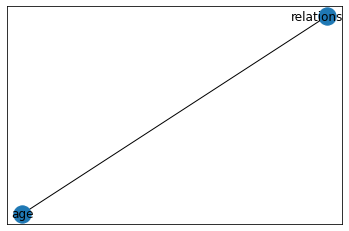

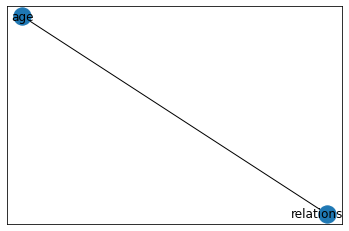

New results added: [('relationship', 'age'), ('marital-status', 'relationship', 'age')]

Processing of occupation:
occupation, workclass, education: score = 0.11633499767211254
occupation, workclass, sex: score = 0.07280750567039107
occupation, workclass, hours-per-week: score = 0.09773296991894008
occupation, education, sex: score = 0.09432231571026091
occupation, education, hours-per-week: score = 0.13047659642918943
occupation, sex, hours-per-week: score = 0.09624013831415616


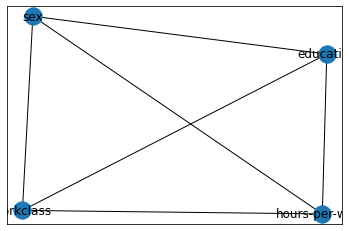

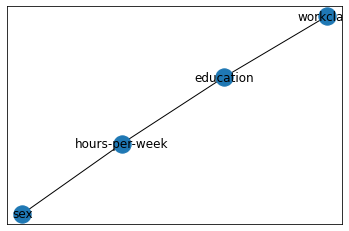

New results added: [('workclass', 'education'), ('education', 'hours-per-week'), ('sex', 'hours-per-week'), ('occupation', 'workclass', 'education'), ('occupation', 'education', 'hours-per-week'), ('occupation', 'sex', 'hours-per-week')]

Processing of relationship:
relationship, marital-status, sex: score = 0.05352448938069859
relationship, marital-status, salary: score = 0.019291008958706946
relationship, sex, salary: score = 0.021951471565579785


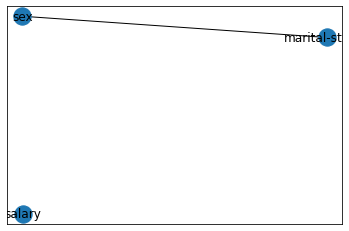

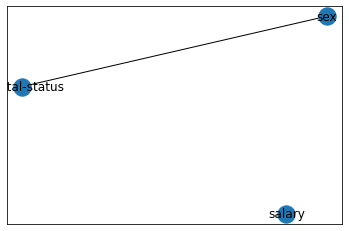

New results added: [('marital-status', 'sex'), ('relationship', 'marital-status', 'sex')]

Processing of race:

Processing of sex:
sex, relationship, occupation: score = 0.19271189537638


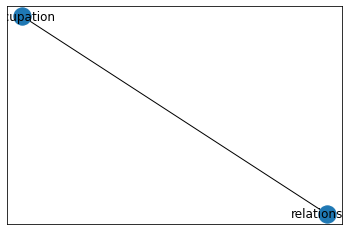

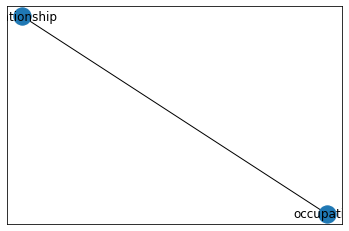

New results added: [('relationship', 'occupation'), ('sex', 'relationship', 'occupation')]

Processing of capital-gain:

Processing of capital-loss:

Processing of hours-per-week:

Processing of native-country:
native-country, race, education-num: score = 0.0648373696790891
native-country, race, fnlwgt: score = 0.06875107251447785
native-country, education-num, fnlwgt: score = 0.08019950612884194


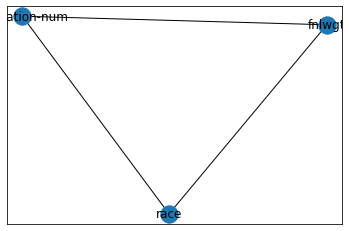

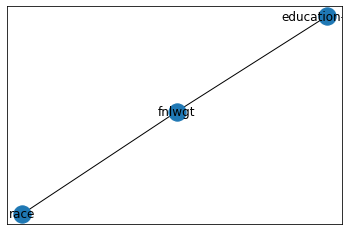

New results added: [('race', 'fnlwgt'), ('education-num', 'fnlwgt'), ('native-country', 'race', 'fnlwgt'), ('native-country', 'education-num', 'fnlwgt')]

Processing of salary:
salary, relationship, capital-gain: score = 0.02028708166016217
salary, relationship, capital-loss: score = 0.01992394015442739
salary, capital-gain, capital-loss: score = 0.018608595368422277



In [12]:
MINIMUM_SCORE = 0.05
result = []

for attribute in mst.nodes:
    lookup = mutinf_triplets_df.loc[mutinf_triplets_df.A == attribute]
    graph = nx.Graph()
    graph.add_nodes_from(mst.neighbors(attribute))
    
    print(f'Processing of {attribute}:')

    for e1, e2, w in zip(lookup['B'], lookup['C'], lookup['score']):
        print(f'{attribute}, {e1}, {e2}: score = {w}')
        if w >= MINIMUM_SCORE:
            graph.add_edge(e1, e2, weight=w)

    if graph.edges:
        nx.draw_networkx(graph)
        plt.show()
        
        tree = nx.maximum_spanning_tree(graph)
        
        nx.draw_networkx(tree)
        plt.show()
        
        new_result = list(tree.edges)
        new_result += [(attribute,) + e for e in tree.edges]
        print(f'New results added: {new_result}')
        result += new_result
    print()

In [13]:
result

[('relationship', 'age'),
 ('marital-status', 'relationship', 'age'),
 ('workclass', 'education'),
 ('education', 'hours-per-week'),
 ('sex', 'hours-per-week'),
 ('occupation', 'workclass', 'education'),
 ('occupation', 'education', 'hours-per-week'),
 ('occupation', 'sex', 'hours-per-week'),
 ('marital-status', 'sex'),
 ('relationship', 'marital-status', 'sex'),
 ('relationship', 'occupation'),
 ('sex', 'relationship', 'occupation'),
 ('race', 'fnlwgt'),
 ('education-num', 'fnlwgt'),
 ('native-country', 'race', 'fnlwgt'),
 ('native-country', 'education-num', 'fnlwgt')]